# A maximally simple solution to CT / CTA detection!

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
pd.set_option('precision', 2)
import matplotlib.pyplot as plt
%matplotlib inline
import pydicom
import os
from glob import glob

In [2]:
DICOM_PATH = 'data/dicom_dir/'
SMILY = u'\U0001F603'

In [3]:
class Cohort(object):
    """ 
    Manages a SHAIP-like cohort of datasets, finding what datasets are available, reading data and GT.
    Deals only with the raw input data - no normalization happens here.  
    Accessors generally present lazy evaluation semantics.
    """
    def __init__(self):
        """ The constructor scans the data path to find what data is present and
        setup a list and dictionary of dataset ids and paths.  It does not *read*
        the data"""
        self.dicom_path = 'data/dicom_dir/'
        self.filepaths = glob(DICOM_PATH + '*.dcm')
        self.ids = [os.path.basename(fp)[:7] for fp in self.filepaths]
        self.id_to_path_map = {id: path for id, path in zip(self.ids, self.filepaths)}
        self.size = len(self.ids)
        
        # Private cache storage
        self._images = self._dicoms = self._groundtruth = None
        
    @property
    def dicoms(self):
        """ Lazily read and return a list of dicom objects in the same order as self.ids """
        if self._dicoms is None:
            self._dicoms = [pydicom.dcmread(fp) for fp in self.filepaths]
        return self._dicoms
        
    @property
    def images(self):
        """ Lazily extract and a list of images (2d numpy arrays) in the same order as self.ids """
        if self._images is None:
            self._images = [dcm.pixel_array for dcm in self.dicoms]
        return self._images
    
    @staticmethod
    def _filename_to_contrast_gt(fname):
        """ Filenames look like this: "ID_0087_AGE_0044_CONTRAST_0_CT.dcm """
        assert fname[17:25] == 'CONTRAST'
        c = fname[26]
        assert c in ('0', '1')
        return int(c)
        
    @property
    def groundtruth(self):
        """ Return a list of ground-truth values as {0, 1} integers in the same order as self.ids"""
        if self._groundtruth is None:
            self._groundtruth = [Cohort._filename_to_contrast_gt(os.path.basename(fp)) for fp in self.filepaths]
        return self._groundtruth
            

def test_cohort_init():
    cohort = Cohort()
    # print(datasets.ids)
    # print(datasets.id_to_path_map)
    assert len(cohort.ids) == 100
    assert len(cohort.ids[0]) == 7 and cohort.ids[0][:3] == 'ID_'
    assert os.path.exists(cohort.filepaths[0])
    print(SMILY, "test_cohort_init passed.")
    
def test_cohort_accessors():
    cohort = Cohort()
    assert len(cohort.dicoms) == len(cohort.ids) == len(cohort.images) == \
           len(cohort.groundtruth) == len(cohort.groundtruth) == len(cohort.filepaths) == cohort.size
    assert all(['PixelData' in dcm for dcm in cohort.dicoms])
    assert len(cohort.images) == len(cohort.ids)
    assert all([im.shape == (512, 512) for im in cohort.images])
    assert all([im.dtype in (np.int16, np.uint16) for im in cohort.images])
    assert all([gt in (0,1) for gt in cohort.groundtruth])
    print(SMILY, "test_cohort_accessors passed.")
                    
def test__filename_to_contrast_gt():
    fname = 'ID_0087_AGE_0044_CONTRAST_0_CT.dcm'
    gt = Cohort._filename_to_contrast_gt(fname)
    assert gt == 0
    print(SMILY, "test__filename_to_contrast_gt passed.")
    

test__filename_to_contrast_gt()
test_cohort_init()
test_cohort_accessors()
    

😃 test__filename_to_contrast_gt passed.
😃 test_cohort_init passed.
😃 test_cohort_accessors passed.


In [4]:
def explore_cohort():
    cohort = Cohort()
    df = pd.DataFrame(columns=['ID', 'MinV', 'MaxV', 'Slope', 'Incpt', 'MmPerPix', 'Padding'])
    for ix in range(cohort.size):
        image = cohort.images[ix]
        dcm = cohort.dicoms[ix]
        id_ = cohort.ids[ix]
        padding = dcm.data_element('PixelPaddingValue').value if 'PixelPaddingValue' in dcm else None
        slope = dcm.data_element('RescaleSlope').value
        intercept = dcm.data_element('RescaleIntercept').value
        mmpp_x, mmpp_y = dcm.data_element('PixelSpacing').value
        assert mmpp_x == mmpp_y
        row = (id_, np.min(image), np.max(image), slope, intercept, mmpp_x, padding)

        df.loc[ix] = row
        
    display(df.describe(include='all'))
    display(df)
        
explore_cohort()

,ID,MinV,MaxV,Slope,Incpt,MmPerPix,Padding
count,100,100.0,100.0,1.00e+02,100.00,100.00,33.0
unique,100,4.0,77.0,NaN,NaN,NaN,2.0
top,ID_0025,0.0,4095.0,NaN,NaN,NaN,-2000.0
freq,1,66.0,17.0,NaN,NaN,NaN,21.0
mean,NaN,NaN,NaN,1.00e+00,-1013.76,0.73,NaN
std,NaN,NaN,NaN,7.67e-05,102.40,0.13,NaN
min,NaN,NaN,NaN,1.00e+00,-1024.00,0.54,NaN
25%,NaN,NaN,NaN,1.00e+00,-1024.00,0.65,NaN
50%,NaN,NaN,NaN,1.00e+00,-1024.00,0.70,NaN
75%,NaN,NaN,NaN,1.00e+00,-1024.00,0.77,NaN


,ID,MinV,MaxV,Slope,Incpt,MmPerPix,Padding
0,ID_0096,-1024,2187,1.0,-1024.0,0.90,63536
1,ID_0012,0,2505,1.0,-1024.0,0.74,None
2,ID_0068,0,2476,1.0,-1024.0,0.98,None
3,ID_0045,0,4095,1.0,-1024.0,0.98,None
4,ID_0051,-1024,4095,1.0,-1024.0,0.75,63536
5,ID_0084,0,2148,1.0,-1024.0,0.98,None
6,ID_0089,-1024,2190,1.0,-1024.0,0.70,63536
7,ID_0014,0,4095,1.0,-1024.0,0.66,None
8,ID_0063,0,3029,1.0,-1024.0,0.98,None
9,ID_0016,0,2194,1.0,-1024.0,0.78,None


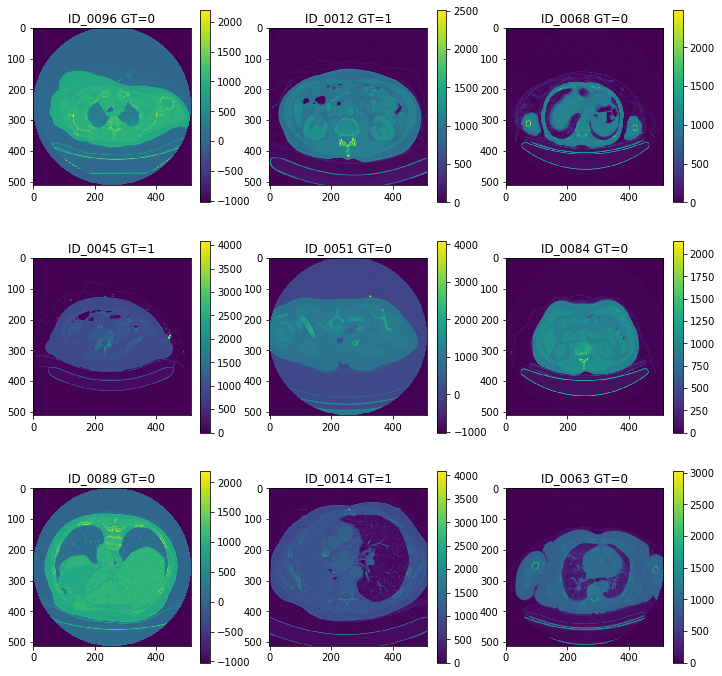

In [13]:
def show_images(cohort):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,12))
    for ix, ax in enumerate(axes.flat):   # Show just a selection
        im = cohort.images[ix]
        gt = cohort.groundtruth[ix]
        pltim = ax.imshow(im)
        ax.set_title("%s GT=%d"% (cohort.ids[ix], gt))
        cbar=fig.colorbar(pltim, ax=ax)
    plt.show()
        
show_images(cohort=Cohort())

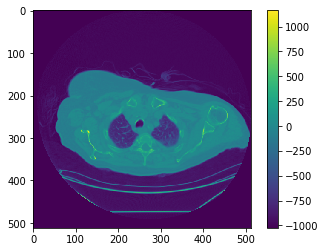

😃 test__preprocess_one_dicom passed.
😃 test_preprocessed_cohort_accessors passed.


In [9]:
class PreprocessedCohort(object):
    """ 
    Represents cohort of data with basic pre-procession applied.  For example, deal with padding,
    conversion to Hounsfield etc.  At this stage we are no longer concerned with file formats, directories
    etc.
    """
    def __init__(self, cohort):
        dicoms = cohort.dicoms
        
        self.size = cohort.size
        self.ids = cohort.ids
        self.groundtruth = cohort.groundtruth
        self._preprocessed_images = [PreprocessedCohort._preprocess_one_dicom(dcm) for dcm in cohort.dicoms]
        
    @staticmethod
    def _preprocess_one_dicom(dcm):
        """ Return a nicely normalised numpy float32 image """
        raw_image = dcm.pixel_array
        padding = dcm.data_element('PixelPaddingValue').value if 'PixelPaddingValue' in dcm else None
        # print(raw_image.dtype)
        slope = dcm.data_element('RescaleSlope').value
        intercept = dcm.data_element('RescaleIntercept').value
        
        image = np.array(raw_image, dtype=np.float32)
        image = image * slope + intercept
        image = np.array(image, dtype=np.float32)
       
        # It seems that padding value lies!  So we'll just clamp image values and hope for the best!
        # print("Image (min,max) = (%6.1f, %6.1f)" % (np.min(image), np.max(image)))
        image[image <= -1024.0] = -1024.0
        image[image >= 2000.0] = 2000.0
            
        assert np.min(image) >= -1024.0
        assert np.max(image) <= 2000.0
            
        return image
        
        
    @property
    def images(self):
        """ Lazily apply normalisation """
        return self._preprocessed_images
    
def test__preprocess_one_dicom():
    cohort = Cohort()
    dcm1 = cohort.dicoms[0]
    image = PreprocessedCohort._preprocess_one_dicom(dcm1)
    plt.imshow(image)
    plt.colorbar()
    plt.show()
    print(SMILY, "test__preprocess_one_dicom passed.")
    
def test_preprocessed_cohort_accessors():
    ppch = PreprocessedCohort(Cohort())
    assert len(ppch.images) == len(ppch.ids) == len(ppch.groundtruth) == ppch.size
    print(SMILY, "test_preprocessed_cohort_accessors passed.")
    
test__preprocess_one_dicom()
test_preprocessed_cohort_accessors()

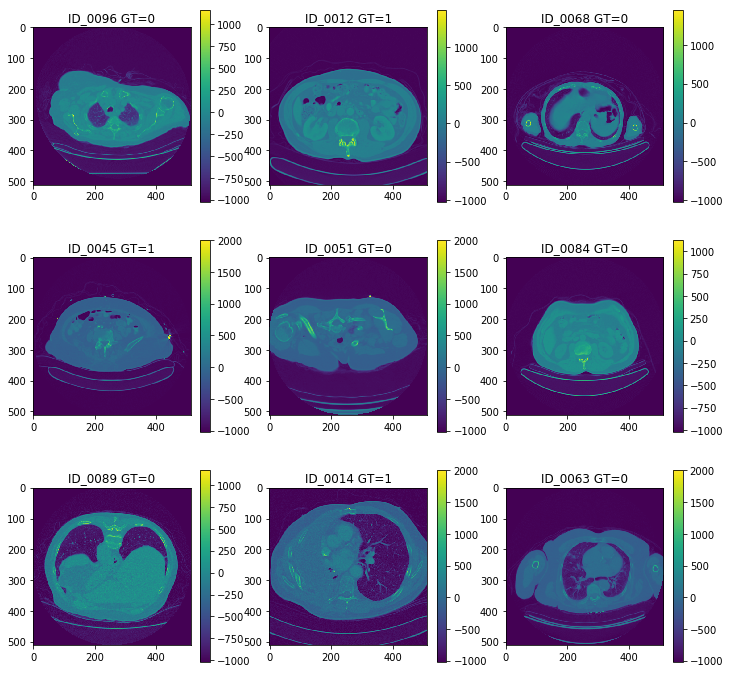

In [14]:
show_images(PreprocessedCohort(Cohort()))

In [ ]:
a = np.array([1,2,3])